In [2]:
from Utils2.Dataset import Unrolled_Dataset
from Utils2.Unrolled_3iteration import Physics
from Utils2.Unrolled_3iteration import SamplingFunction
from Utils2.Unrolled_3iteration import UnrolledReconstructor
from Utils2.Model_norm import TinyUNET

import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from monai.metrics.regression import SSIMMetric
import matplotlib.pyplot as plt
import numpy as np
import os

In [33]:
def show_reconstruction_logscaled(zf, recon, gt, idx=0, eps=1e-5):
    # Compute log-magnitude images
    zf_mag = np.log(np.abs(zf[idx, 0].cpu().detach().numpy()) + eps)
    recon_mag = np.log(np.abs(recon[idx, 0].cpu().detach().numpy()) + eps)
    gt_mag = np.log(np.abs(gt[idx, 0].cpu().detach().numpy()) + eps)

    # Stack for shared color scaling
    all_imgs = np.stack([zf_mag, recon_mag, gt_mag], axis=0)
    vmin, vmax = np.min(all_imgs), np.max(all_imgs)

    titles = ['S', 'W_e', 'S + W_e Alpha=0.3']
    images = [zf_mag, recon_mag, gt_mag]

    fig, axes = plt.subplots(1, 3, figsize=(15, 15), constrained_layout=True)

    for ax, img, title in zip(axes, images, titles):
        im = ax.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
        ax.set_title(title, fontsize=18)
        ax.axis('on')

    # Shared colorbar
    fig.colorbar(im, ax=axes, fraction=0.015, pad=0.04)
    plt.show()

### 1. Dataset and DataLoader

In [3]:
data_path = 'C:/Users/garci/Desktop/FastMRI_dataset/multicoil_val_prepro_valida_dataset_2/multicoil_val_prepro_valid_dataset'

#C:\Users\garci\Desktop\FastMRI_dataset\multicoil_train_small_prepro_valid_dataset
dataset = Unrolled_Dataset(unroll_root_dir=data_path, transform=True)
train_data = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=16, pin_memory=True, persistent_workers=True)

for i, (zf, us, cs, gt) in enumerate(train_data):
    print(f"Batch {i}:")
    print(f"  ZF shape: {zf.shape}")  # (B, 1, 320, 320)
    print(f"  US shape: {us.shape}")  # (B, 15, 640, 115)
    print(f"  CS shape: {cs.shape}")  # (B, 15, 320, 320)
    print(f"  GT shape: {gt.shape}")  # (B, 1, 320, 320)
    break  # Only first batch

Found files:
  Zero-filled:         2484
  Coil sensitivity:    2484
  Undersampled:        2484
  Ground truth (Cs):   2484
Batch 0:
  ZF shape: torch.Size([8, 1, 320, 320])
  US shape: torch.Size([8, 15, 640, 115])
  CS shape: torch.Size([8, 15, 320, 320])
  GT shape: torch.Size([8, 1, 320, 320])


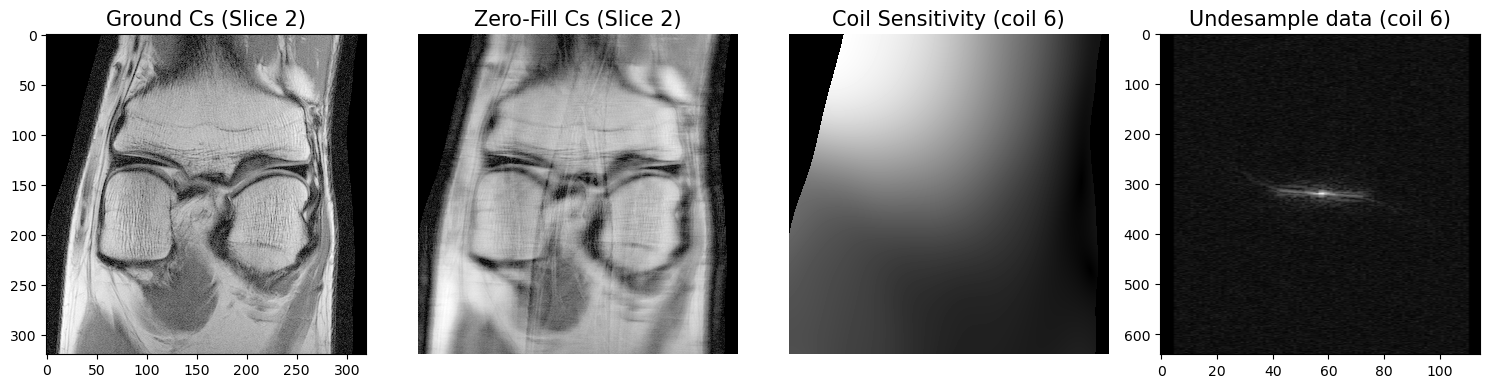

In [35]:
def safe_plot(data, epsilon = 1e-5):
    return np.log(np.abs(data) + epsilon)

coil = 6
index = 2
fontsize = 15
# Plot
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

axes[0].imshow(safe_plot(gt[index,0]), cmap='gray')
axes[0].set_title(f'Ground Cs (Slice {index})', fontsize = fontsize)
#axes[0].axis('off')

axes[1].imshow(safe_plot(zf[index,0]), cmap='gray')
axes[1].set_title(f'Zero-Fill Cs (Slice {index})', fontsize = fontsize)
axes[1].axis('off')

axes[2].imshow(safe_plot(cs[index,coil],1e-1), cmap='gray')
axes[2].set_title(f'Coil Sensitivity (coil {coil})', fontsize = fontsize)
axes[2].axis('off')

axes[3].imshow(safe_plot(us[index,coil]), cmap = 'gray', aspect = 0.18)
axes[3].set_title(f'Undesample data (coil {coil})', fontsize = fontsize)
#axes[3].axis('off')

plt.tight_layout()
plt.show()

### 2. Physics

In [31]:
sampler = SamplingFunction()
physics = Physics(alpha=0.1, sampler=sampler)
W_e = physics._compute_W_e(us, cs)
S = physics._compute_S(zf, cs)
input = physics._final_sum(S, W_e)

# Shapes
print(f"W_e shape: {W_e.shape}")
print(f"S   shape: {S.shape}")
print(f"Input shape: {input.shape}")

# Min and max magnitudes
# Check min/max magnitudes
print(f"  ZF magnitude min: {zf.abs().min().item():.4e}, max: {zf.abs().max().item():.4e}")
print(f"  US magnitude min: {us.abs().min().item():.4e}, max: {us.abs().max().item():.4e}")
print(f"  CS magnitude min: {cs.abs().min().item():.4e}, max: {cs.abs().max().item():.4e}")
print(f"W_e magnitude min: {W_e.abs().min().item():.4e}, max: {W_e.abs().max().item():.4e}")
print(f"S   magnitude min: {S.abs().min().item():.4e}, max: {S.abs().max().item():.4e}")
print(f"Input magnitude min: {input.abs().min().item():.4e}, max: {input.abs().max().item():.4e}")
print(f"GT magnitude min: {gt.abs().min().item():.4e}, max: {gt.abs().max().item():.4e}")

W_e shape: torch.Size([8, 1, 320, 320])
S   shape: torch.Size([8, 1, 320, 320])
Input shape: torch.Size([8, 1, 320, 320])
  ZF magnitude min: 0.0000e+00, max: 5.6810e-04
  US magnitude min: 0.0000e+00, max: 1.1964e-02
  CS magnitude min: 0.0000e+00, max: 9.7023e-01
W_e magnitude min: 0.0000e+00, max: 5.6810e-05
S   magnitude min: 0.0000e+00, max: 5.0950e-04
Input magnitude min: 0.0000e+00, max: 5.6632e-04
GT magnitude min: 0.0000e+00, max: 6.1313e-04


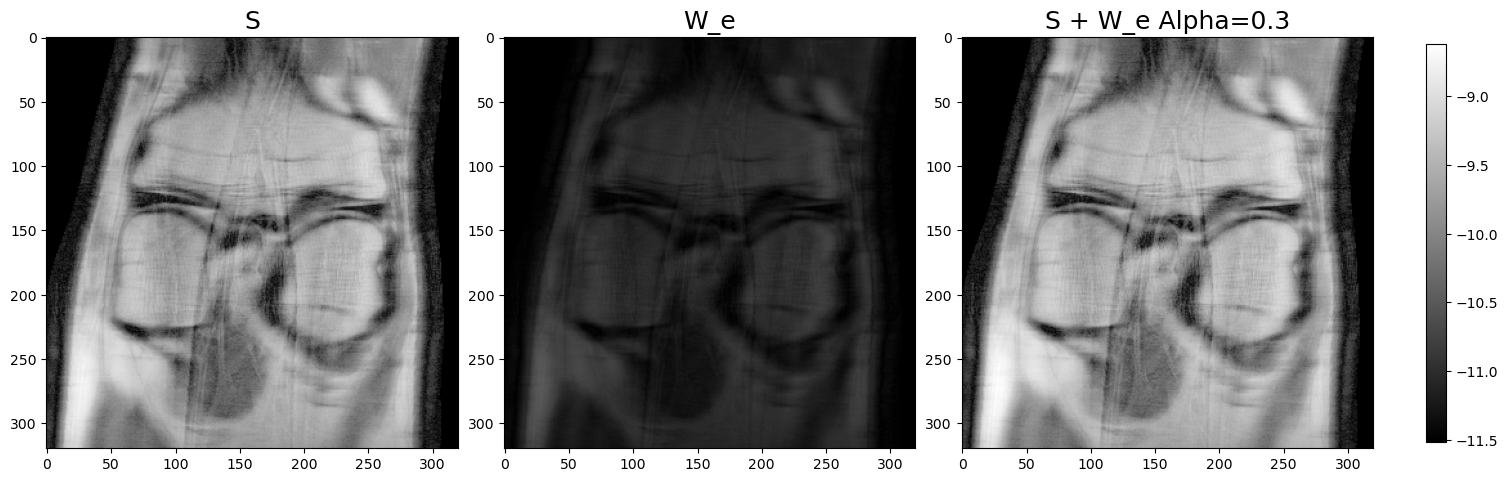

In [32]:
show_reconstruction_logscaled(S, W_e, input, idx=2, eps=1e-5)

### 3. Deep learning model (UNETxComplex)

In [4]:
log_dir="C:/Users/garci/DLxBIO/Unrolled_Optimization/Log_dir"
writer = SummaryWriter(log_dir=log_dir)
# Data
real = torch.randn(1, 1, 320, 320)
imag = torch.randn(1, 1, 320, 320)
model_input = torch.complex(real, imag)
model = TinyUNET()
# Log the graph
writer.add_graph(model, model_input)
writer.close()

### 4. Unrroll physics and DL model

In [5]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

# Sent the data to device
model1, model2, model3 = TinyUNET().to(device), TinyUNET().to(device), TinyUNET().to(device)
zf, us, cs = zf.to(device), us.to(device), cs.to(device)

# Initialize the unrolled reconstructor
reconstructor = UnrolledReconstructor(model1, model2, model3).to(device)

# Forward pass
output = reconstructor(zf, us, cs)

# Print shapes (optional sanity check)
print(f"ZF shape: {zf.shape}")
print(f"US shape: {us.shape}")
print(f"CS shape: {cs.shape}")
print(f"Output shape: {output.shape}")

# Compute min and max of magnitudes
print(f"ZF magnitude min: {zf.abs().min().item():.4e}, max: {zf.abs().max().item():.4e}")
print(f"US magnitude min: {us.abs().min().item():.4e}, max: {us.abs().max().item():.4e}")
print(f"CS magnitude min: {cs.abs().min().item():.4e}, max: {cs.abs().max().item():.4e}")
print(f"Output magnitude min: {output.abs().min().item():.4e}, max: {output.abs().max().item():.4e}")

#show_reconstruction_logscaled(zf, output, gt, idx = 3, eps=1e-5)

Using device: cuda
ZF shape: torch.Size([8, 1, 320, 320])
US shape: torch.Size([8, 15, 640, 115])
CS shape: torch.Size([8, 15, 320, 320])
Output shape: torch.Size([8, 1, 320, 320])
ZF magnitude min: 0.0000e+00, max: 4.2090e-04
US magnitude min: 0.0000e+00, max: 9.1102e-03
CS magnitude min: 0.0000e+00, max: 9.5534e-01
Output magnitude min: 1.0849e-03, max: 5.7405e+00


### 6. Training loop

In [6]:
class LogMSELoss(nn.Module):
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps

    def forward(self, pred, target):
        pred_log = torch.log(torch.abs(pred) + self.eps)
        target_log = torch.log(torch.abs(target) + self.eps)
        return torch.mean((pred_log - target_log) ** 2)

def initialize_weights(model):
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.Linear):
            nn.init.xavier_normal_(module.weight)
            nn.init.constant_(module.bias, 0)

# Loss & optimizer
#criterion = LogMSELoss()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
ssim_metric = SSIMMetric(spatial_dims=2)

# Models
model1, model2, model3 = TinyUNET().to(device), TinyUNET().to(device), TinyUNET().to(device)
reconstructor = UnrolledReconstructor(model1, model2, model3).to(device)
initialize_weights(reconstructor)

# Training loop
for epoch in range(1, 15):
    reconstructor.train()
    train_loss = 0
    ssim_total = 0
    ssim_count = 0

    for i, (zf, us, cs, gt) in enumerate(train_data):
        print(f"Epoch {epoch}, Batch {i+1}", end='\r')

        # Move to device
        zf, us, cs, gt = zf.to(device), us.to(device), cs.to(device), gt.to(device)

        # Forward
        pred = reconstructor(zf, us, cs)

        # Loss
        loss = criterion(pred.real, gt.real) + criterion(pred.imag, gt.imag)
        #loss = criterion(pred, gt)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * zf.size(0)

        # SSIM computation
        pred_mag = pred.abs()
        gt_mag = gt.abs()

        # Normalize to [0, 1] for SSIM stability
        pred_mag = pred_mag / (pred_mag.max() + 1e-8)
        gt_mag = gt_mag / (gt_mag.max() + 1e-8)

        ssim_score = ssim_metric(pred_mag, gt_mag)
        ssim_total += ssim_score.mean().item()
        ssim_count += 1

        # # (Optional) Debugging info
        # print(f"Prediction magnitude min: {pred_mag.min().item():.4f}, max: {pred_mag.max().item():.4f}")
        # print(f"Ground Truth magnitude min: {gt_mag.min().item():.4f}, max: {gt_mag.max().item():.4f}")

    # Epoch stats
    epoch_train_loss = train_loss / len(train_data.dataset)
    epoch_ssim = ssim_total / ssim_count
    print(f"Epoch {epoch:02d} | Loss: {epoch_train_loss:.4f} | SSIM: {epoch_ssim:.4f}")

Epoch 01 | Loss: 7.1947 | SSIM: 0.1965
Epoch 02 | Loss: 7.2062 | SSIM: 0.1943
Epoch 03 | Loss: 7.2034 | SSIM: 0.1938
Epoch 04 | Loss: 7.1968 | SSIM: 0.1945
Epoch 05 | Loss: 7.2087 | SSIM: 0.1959
Epoch 06 | Loss: 7.2025 | SSIM: 0.1958
Epoch 07 | Loss: 7.1962 | SSIM: 0.1964
Epoch 08 | Loss: 7.2053 | SSIM: 0.1936
Epoch 09 | Loss: 7.2056 | SSIM: 0.1973
Epoch 10 | Loss: 7.1953 | SSIM: 0.1973
Epoch 11 | Loss: 7.1963 | SSIM: 0.1967
Epoch 12 | Loss: 7.2014 | SSIM: 0.1946
Epoch 13 | Loss: 7.2002 | SSIM: 0.1980
Epoch 14 | Loss: 7.2011 | SSIM: 0.1964


### 7. Final reconstruction

In [11]:
for i, (zf, us, cs, gt) in enumerate(train_data):
    print(f"Batch {i}:")
    print(f"  ZF shape: {zf.shape}")  # (B, 1, 320, 320)
    print(f"  US shape: {us.shape}")  # (B, 15, 640, 115)
    print(f"  CS shape: {cs.shape}")  # (B, 15, 320, 320)
    print(f"  GT shape: {gt.shape}")  # (B, 1, 320, 320)
    break

zf, us, cs, gt = zf.to(device), us.to(device), cs.to(device), gt.to(device)
output = reconstructor(zf, us, cs)

Batch 0:
  ZF shape: torch.Size([8, 1, 320, 320])
  US shape: torch.Size([8, 15, 640, 115])
  CS shape: torch.Size([8, 15, 320, 320])
  GT shape: torch.Size([8, 1, 320, 320])


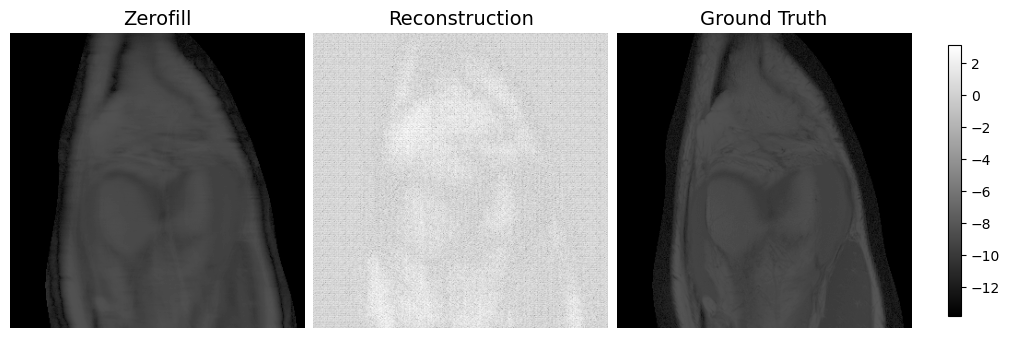

In [15]:
show_reconstruction_logscaled(zf, output, gt, idx = 2, eps=1e-6)